# Optimization (tutorial)

In this tutorial you will learn to code and use common optimization algorithms for static models.


---

## Profit optimization by a monopolist

A monopolist produces quantity $q$ of goods X at price $p$. Its cost function is $c(q) = 0.5 + q (1-qe^{-q})$

The consumer's demand for price $p$ is $x(p)=2 e^{-0.5 p}$ (constant elasticity of demand to price).

__Write down the profit function of the monopolist and find the optimal production (if any). Don't use any library except for plotting.__



The monopolist chooses the quantity $q$ that maximizes its profit [^footnote] :

$$
\pi(q) = q p(q) - c(q)
$$

(where the inverse demand function is $p(q) = 2 \log(2) - \log(q)$

[^footnote]: here it is obviously equivalent to maximize w.r.t. $p$ or w.r.t. $q$.

In [10]:
# we start by defining and plotting the functions to be maximized

c(q) = 0.5 + q*(1-q*exp(-q))
x(p) = 2*exp(-0.5*p)
price(q) = 2 * log(2) - 2 * log(q)
pi(q) = q*price(q) - c(q)   # we don't use greek symbol π to not overload π constant

pi (generic function with 1 method)

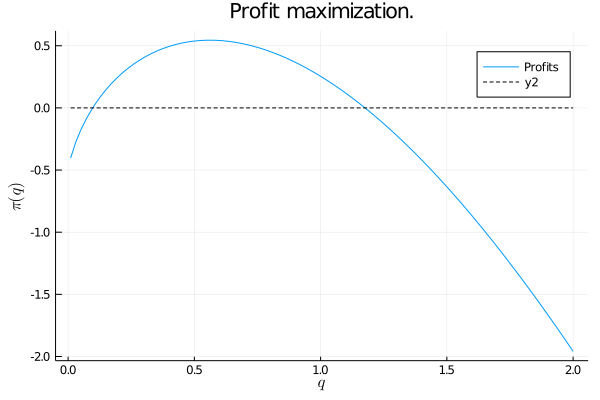

In [11]:
using Plots
qvec = range(0.01, 2.0; length=100)
pivec = pi.(qvec)
pl = plot(qvec,pivec, label="Profits", xlabel="\$q\$", ylabel="\$\\pi(q)\$", title="Profit maximization.")
plot!(pl, qvec,pivec*0, color="black", linestyle=:dash)

We see on the graph the profit function is clearly concave. We'll maximize it using a simple bisection algorithm.

In [12]:
function bisection(f::Function, a::Float64, b::Float64; ϵ=1e-5)
    ## the function will procure ϵ accuracy on the maximand of f
    N = log((b-a)/ϵ)/log(2)
    an = a
    fa = f(a)
    bn = b
    fb = f(b)
    for it = 1:N
        cn = (an+bn)/2
        fc = f(cn)
        if fa>fb
            bn = cn
            fb = fc
        else
            an = cn
            fa = fc
        end
    end
    return (an+bn)/2
    
end

bisection (generic function with 1 method)

In [13]:
bisection(pi, 0.1, 2.0)

0.5750072479248047

---

## (modified) Solow model

This model tries to explain long-term productivity, its relation to productivity and the speed of convergence.

The setup is the following:

- a country accumulates capital $k_t$
- population $n_t$ grows at rate $g$ (so that $n_{t+1}=g n_t$)
- capital and labour are combined to produce $y_t = A F(k_t, n_t)$ where $A>0$ is total factor productivity.
- capital depreciates at rate $\delta \in ]0,1[$. Its law of motion is $k_{t+1}=(1-\delta)k_{t}+i_{t}$ where $i_t$ is the amount invested at time $t$
- production is either consumed or invested: $y_t = c_t + i_t$

We choose a Cobb-Douglas specification with constant returns to scale $F(k_t, n_t) = k_t^{\alpha} n_t^{1-\alpha}$.

In the Ramsey–Cass–Koopmans  model (also called neoclassical growth model), a representative agent would choose $c_t$ in every period so as to maximize an intertemporal utility like $\sum_{t \geq 0} \beta^t U(c_t)$ where $\beta \in [0,1[$ is a time discount and $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ is the instantaneous felicity.

Here we follow the Solow-Swan specification and assume instead there is a fixed fraction $s\in[0,1[$ of income in every period, which is saved and invested in every period. In other words investment (or savings) is given by:

$$i_t = s y_t$$

As a result, the dynamic of capital and all other variables will be backward looking and can be simulated easily.

__Calibrate parameters $\beta$, $\delta$ and $g$, that is, propose plausible values for them, from the litterature, or by matching some observable fact.__

In [29]:
# We'll create a dictionary of parameters
p = Dict(
    :α=>0.3,
    :β=>0.96,
    :δ=>0.1,
    :g=>1.01,
    :s=>0.2
)

Dict{Symbol,Float64} with 5 entries:
  :α => 0.3
  :s => 0.2
  :δ => 0.1
  :g => 1.01
  :β => 0.96

__Detrend the equations of the model w.r.t. population growth. Denote the detrended variables with a hat (in the code we assume all variables are detrended and ignore the hat).__

Our goal is to compute the steady-state and assess its stability.

__Compute a function `f` which returns the capital $\hat{k}_{t+1}$ as a function of $\hat{k_t}$. It is suggested to define `f(k::Float64, p::Dict{Symbol, Float64})` where `p` is a dictionary of parameters.__

 (note: such a dictionary can be defined as `p = Dict(:a=>0.9, :b=>4)` and accessed with brackets `p[:a]` or `p[:b]`) (note2: symbols like `:a` or `:b` are lightweight string. The content must be a valid julia identifier so that it is valid to write `a=p[:a]`)

In [32]:
function f(k,p)
    α = p[:α]
    δ = p[:δ]
    g = p[:g]
    s = p[:s]
    i = k^α*s
    knext = (1-δ)/g + 1/g*i
    return knext
end

f (generic function with 1 method)

__Starting from an initial level $\hat{k}_0$ compute successive iterates of `f` to find the long-run level $\overline{k}$ of capital per capita. (Bonus: produce a nice plot of the convergence)__

In [73]:
function simulate(k0, p, log=false; maxit=1000, tol_η=1e-6)
    k=k0
    if log
        trace = Float64[k]
    end
    for it=1:maxit
        print(k)
        if log
            push!(trace, copy(k))
        end
        k = f(k0, p)
        η = abs(k-k0)
        if η<tol_η
            break
        end
        k0 = k
    end
    
    if log
        return (k,trace)
    else
        return k
    end
end

simulate (generic function with 4 methods)

In [74]:
k_inf, trace =  simulate(0.1, p, true)

0.10.99033410566876681.08853274604265061.09421302992899031.09453043896681311.094548141432438

(1.0945491286245745, [0.1, 0.1, 0.9903341056687668, 1.0885327460426506, 1.0942130299289903, 1.0945304389668131, 1.094548141432438])

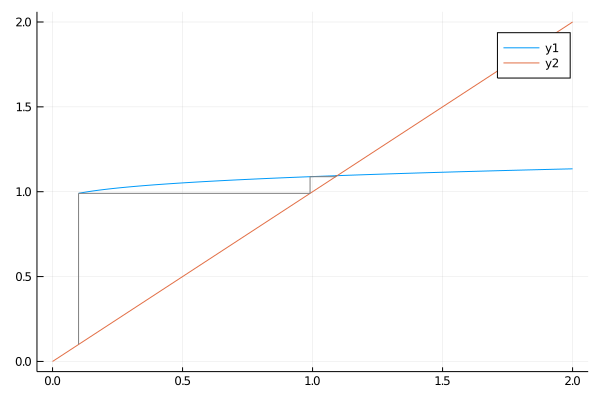

In [78]:
using Plots
k_vec = range(0.1, 2.0; length=100)
knext_vec = [f(u, p) for u in k_vec]
pl = plot(k_vec, knext_vec)
plot!(pl, [0.0, 2.0], [0.0, 2.0])
for i in 1:(length(trace)-1)
    plot!(pl, [trace[i], trace[i]], [trace[i], trace[i+1]], label="", color="grey")
    plot!(pl, [trace[i], trace[i+1]], [trace[i+1], trace[i+1]], label="", color="grey")
end
pl

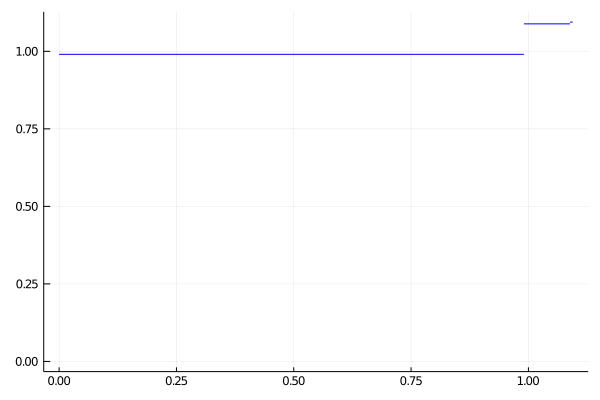

In [69]:
pl = plot()
for i in 1:(length(trace)-1)
    plot!(pl, [trace[i], trace[i+1]], [trace[i+1], trace[i+1]], label="", color="blue")
end
pl

In [60]:
trace

1001-element Array{Float64,1}:
 0.0
 0.0
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 ⋮
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668
 0.9903341056687668

__What factors affect the steady-state level of capital?__

__Study the stability of $f$ around $\overline{k}$. Which factors affect the speed of convergence towards the steady-state?__

__Compute the steady-state directly using a Newton method and compare convergence speed.__

__Suppose one tries to maximize steady-state consumption by choosing saving rate $s$. Which value would one choose?__

__(Bonus) Suppose an agent is given the intertemporal utility from the Ramsey–Cass–Koopmans model but chooses saving rate once for all. Which saving rate would one choose? Is it the same for all initial levels of capital?__



---

## Exercise: constrained optimization

Consider the function $f(x,y) = 1-(x-0.5)^2 -(y-0.3)^2$.

__Use Optim.jl to minimize $f$ without constraint. Check you understand diagnostic information returned by the optimizer.__

__Now, consider the constraint $x<0.3$ and maximize $f$ under this new constraint.__

__Reformulate the problem as a root finding with lagrangians. Write the complementarity conditions.__

__Solve using NLSolve.jl__

---

## Consumption optimization

A consumer has preferences $U(c_1, c_2)$ over two consumption goods $c_1$ and $c_2$.

Given a budget $I$, consumer wants to maximize utility subject to the budget constraint $p_1 c_1 + p_2 c_2 \leq I$.

We choose a Stone-Geary specification where

$U(c_1, c_2)=\beta_1 \log(c_1-\gamma_1) + \beta_2 \log(c_2-\gamma_2)$

__Write the Karush-Kuhn-Tucker necessary conditions for the problem.__

__Verify the KKT conditions are sufficient for optimality.__

__Derive analytically the demand functions, and the shadow price.__

__Interpret this problem as a complementarity problem and solve it using NLSolve.__

__Produce some nice graphs with isoutility curves, the budget constraint and the optimal choice.__

